In [1]:
!pip install xgboost lightgbm catboost shap


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from itertools import cycle
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap
import warnings
warnings.filterwarnings('ignore')

In [153]:
df = pd.read_csv('crop_recommendation.csv')

In [155]:
# Data Cleaning
import numpy as np

# Check for missing values
print("Missing Values:\n", df.isnull().sum())



Missing Values:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [157]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print(f"Removed {duplicates} duplicate rows. New shape: {df.shape}")


Number of duplicate rows: 0


In [161]:
# Detect and handle outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [163]:
# Apply outlier removal to numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    original_count = len(df)
    df = remove_outliers(df, col)
    removed = original_count - len(df)
    print(f"Removed {removed} outliers from {col}. New shape: {df.shape}")

Removed 0 outliers from N. New shape: (2200, 8)
Removed 131 outliers from P. New shape: (2069, 8)
Removed 69 outliers from K. New shape: (2000, 8)
Removed 58 outliers from temperature. New shape: (1942, 8)
Removed 0 outliers from humidity. New shape: (1942, 8)
Removed 58 outliers from ph. New shape: (1884, 8)
Removed 38 outliers from rainfall. New shape: (1846, 8)


In [169]:
# Ensure consistent data types
df[numerical_cols] = df[numerical_cols].astype(float)
df['label'] = df['label'].astype(str)

In [167]:
# Verify cleaned data
print("\nCleaned Data Info:\n", df.info())
print("\nDescriptive Statistics:\n", df.describe())
print("Unique labels:", df['label'].nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 1846 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            1846 non-null   float64
 1   P            1846 non-null   float64
 2   K            1846 non-null   float64
 3   temperature  1846 non-null   float64
 4   humidity     1846 non-null   float64
 5   ph           1846 non-null   float64
 6   rainfall     1846 non-null   float64
 7   label        1846 non-null   object 
dtypes: float64(7), object(1)
memory usage: 129.8+ KB

Cleaned Data Info:
 None

Descriptive Statistics:
                  N            P            K  temperature     humidity  \
count  1846.000000  1846.000000  1846.000000  1846.000000  1846.000000   
mean     54.817443    44.840737    32.812026    25.711188    69.770583   
std      38.550424    22.358561    16.487587     4.155121    22.649324   
min       0.000000     5.000000     5.000000    15.330426    14.258040   
25%

In [4]:
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
    N   P   K  temperature   humidity        ph    rainfall label
0  78  38  43    20.879744  82.002744  6.502985  202.935536  rice
1  79  44  42    21.770462  80.319644  7.038096  226.655537  rice
2  87  51  45    23.004459  82.320763  7.840207  263.964248  rice
3  94  58  35    26.491096  80.158363  6.980401  242.864034  rice
4  62  37  45    20.130175  81.604873  7.628473  262.717340  rice


In [5]:
print("\nLast 5 rows of the dataset:")
print(df.tail())


Last 5 rows of the dataset:
        N   P   K  temperature   humidity        ph    rainfall   label
2195  107  31  33    26.774637  66.413269  6.780064  177.774507  coffee
2196   82  23  34    27.417112  56.636362  6.086922  127.924610  coffee
2197  113  25  32    24.131797  67.225123  6.362608  173.322839  coffee
2198  108  38  30    26.272418  52.127394  6.758793  127.175293  coffee
2199  117  27  29    23.603016  60.396475  6.779833  140.937041  coffee


In [6]:
print("\nTotal number of elements:", df.size)
print("Shape of the dataset:", df.shape)
print("Column names:", df.columns.tolist())
print("Unique crop labels:", df['label'].unique())


Total number of elements: 17600
Shape of the dataset: (2200, 8)
Column names: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
Unique crop labels: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


In [7]:
print("\nData types:")
print(df.dtypes)


Data types:
N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object


In [8]:
print("\nLabel value counts:")
print(df['label'].value_counts())


Label value counts:
label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64


<Figure size 1200x800 with 0 Axes>

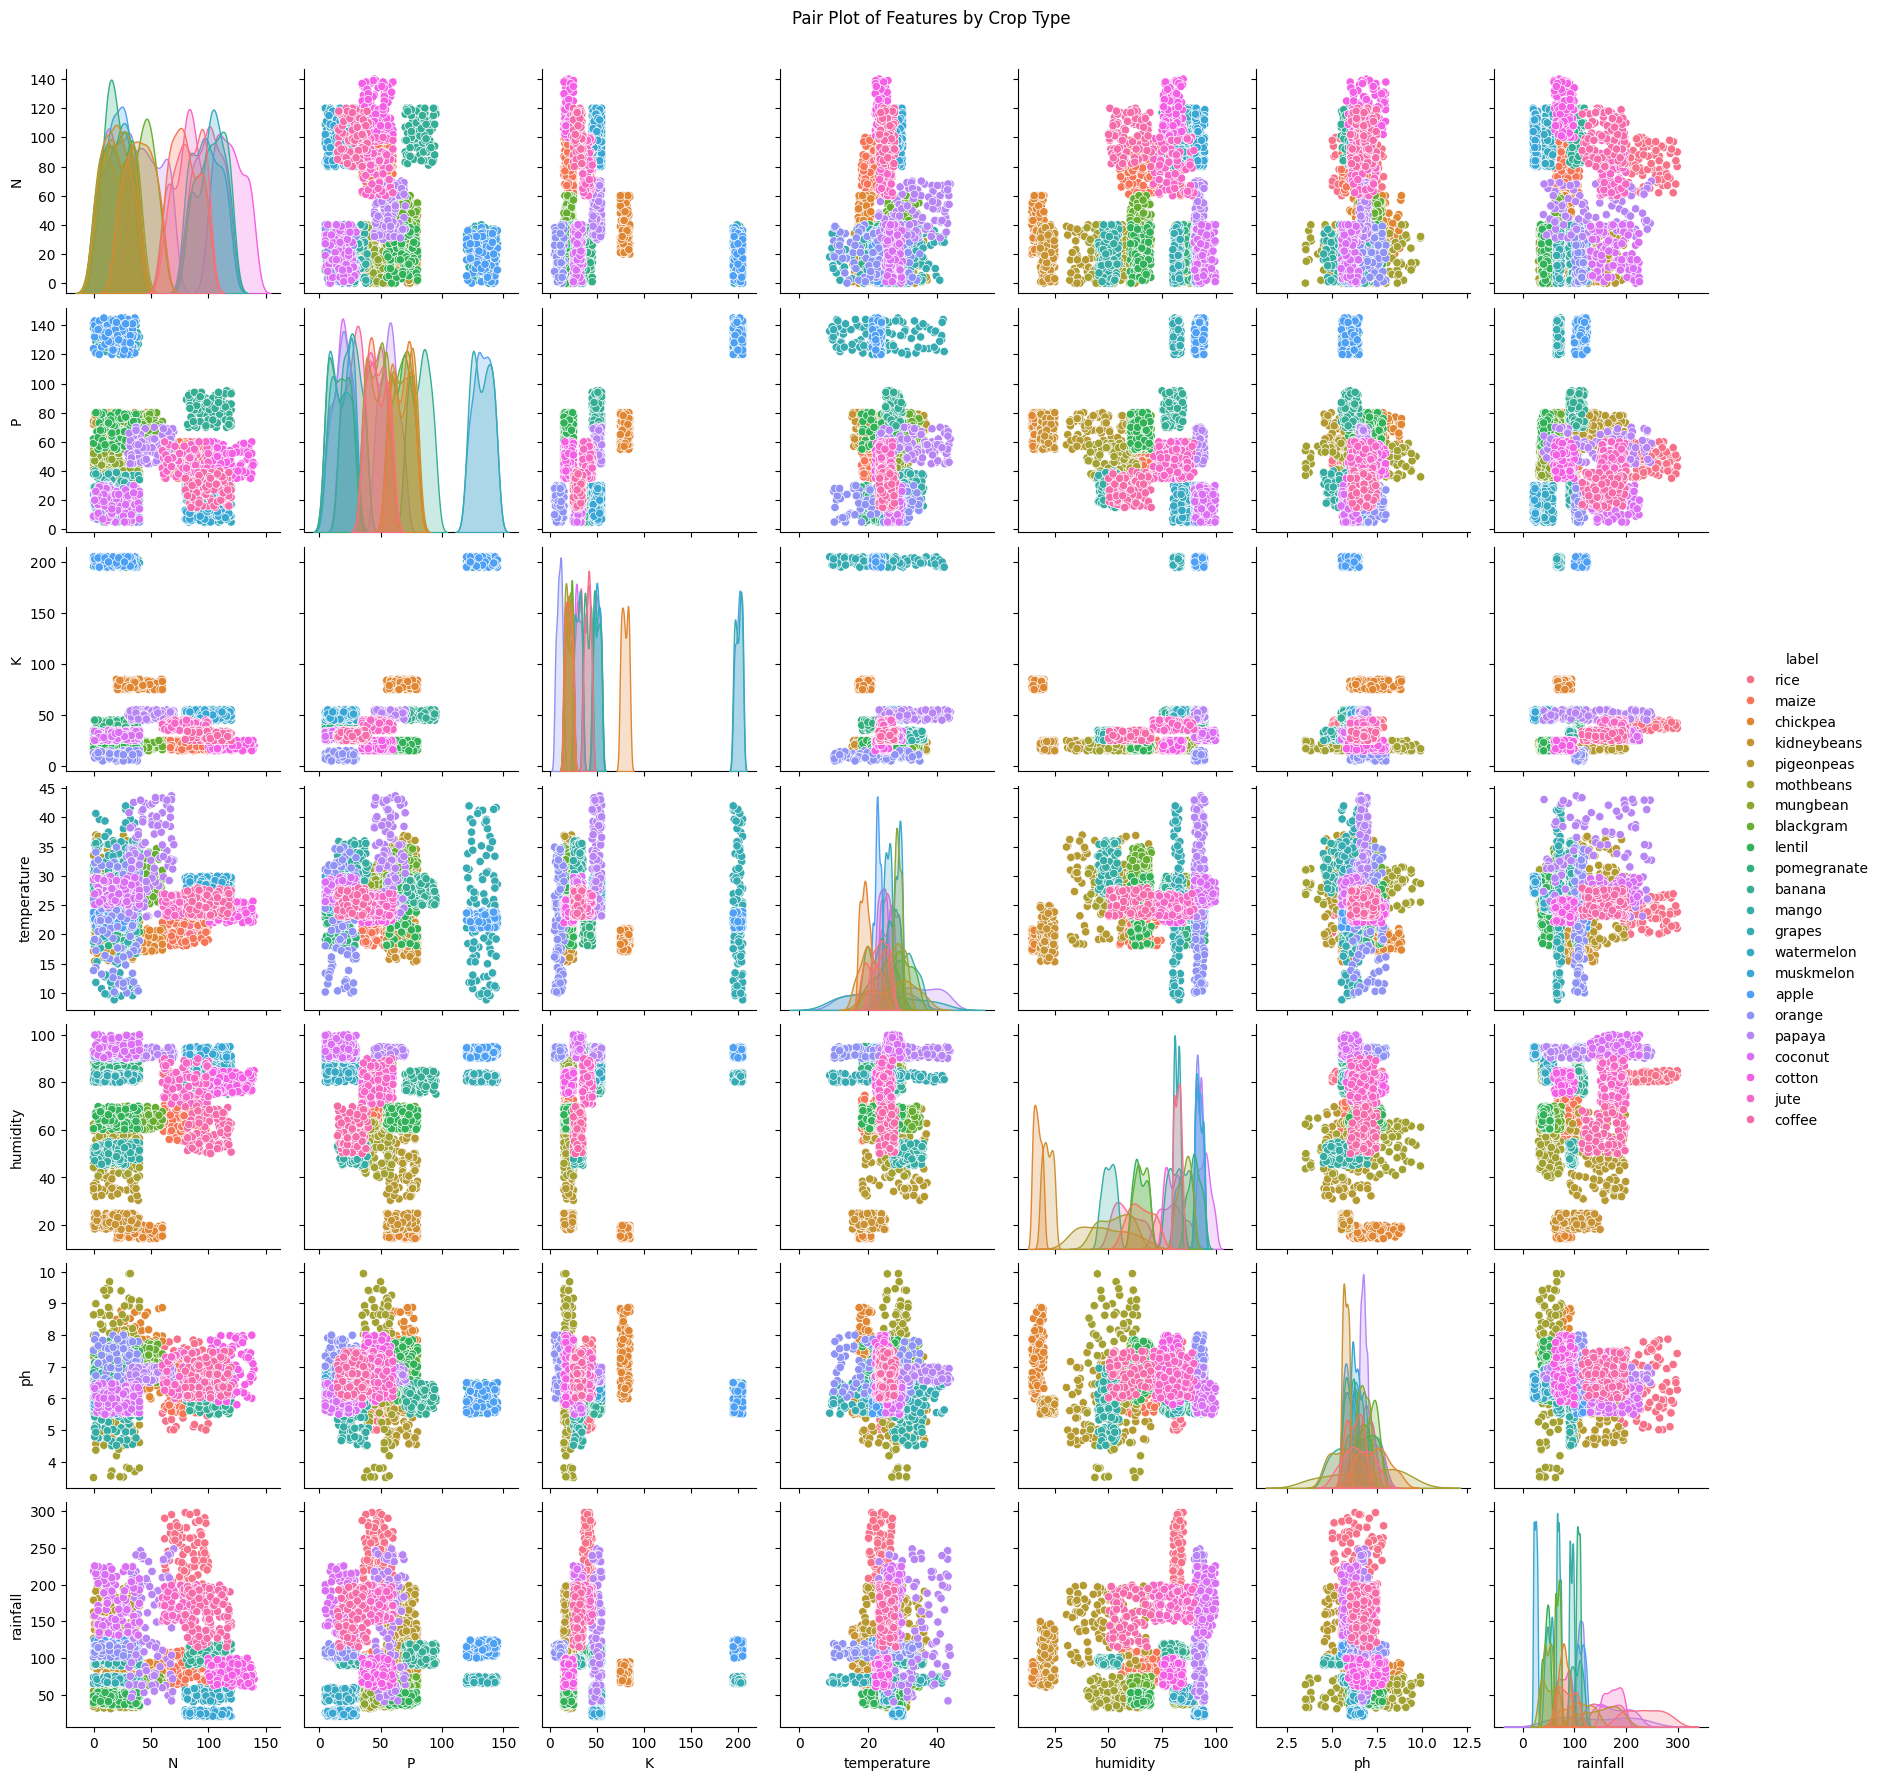

In [9]:
# Dataset visualizations
# Pair plot
plt.figure(figsize=[12, 8])
sns.pairplot(df, hue='label', diag_kind='kde')
plt.suptitle('Pair Plot of Features by Crop Type', y=1.02)
plt.show()

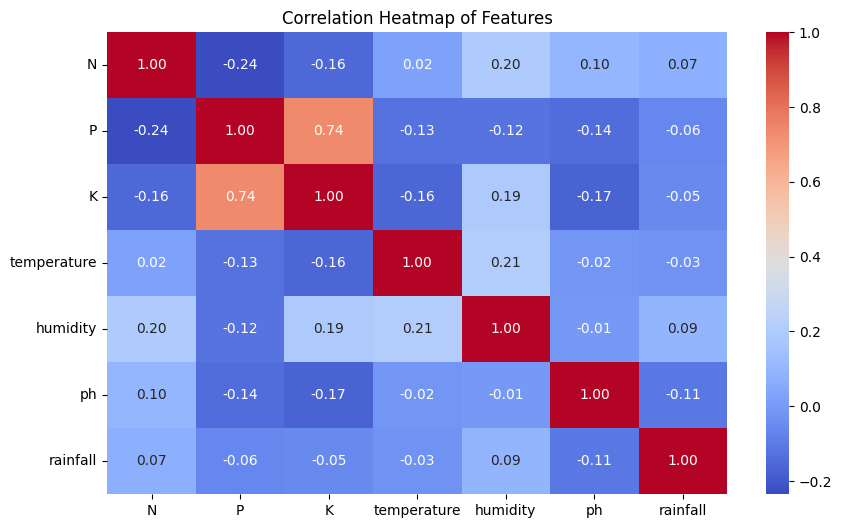

In [10]:
plt.figure(figsize=[10, 6])
sns.heatmap(df.drop('label', axis=1).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

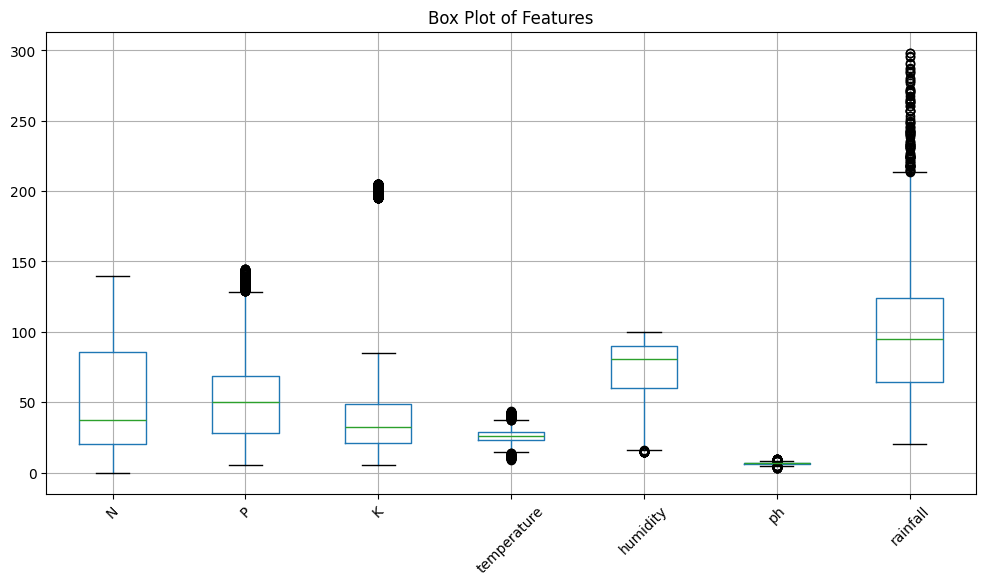

In [11]:
# Box plot
plt.figure(figsize=[12, 6])
df.drop('label', axis=1).boxplot()
plt.xticks(rotation=45)
plt.title('Box Plot of Features')
plt.show()

In [12]:
df['label'].value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

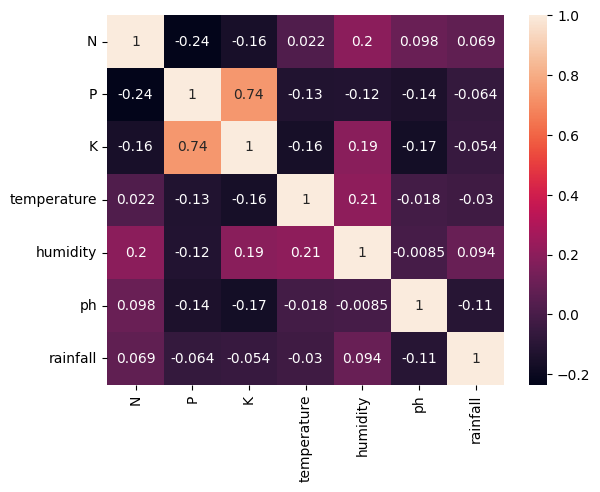

In [13]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

In [14]:
features = df[['N', 'P','K','temperature', 'humidity', 'ph', 'rainfall']]
target = df['label']
#features = df[['temperature', 'humidity', 'ph', 'rainfall']]
labels = df['label']

In [15]:
# Initialzing empty lists to append all model's name and corresponding name
acc = []
model = []

In [16]:
# Feature Engineering
# Create interaction features
df['N_P_ratio'] = df['N'] / (df['P'] + 1e-6)  # Avoid division by zero
df['temp_humidity'] = df['temperature'] * df['humidity']
df['ph_rainfall'] = df['ph'] * df['rainfall']

In [45]:
# Polynomial features for linear models
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df.drop('label', axis=1))
poly_cols = poly.get_feature_names_out(df.drop('label', axis=1).columns)
df_poly = pd.DataFrame(poly_features, columns=poly_cols)

In [41]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('label', axis=1))
df_scaled = pd.DataFrame(scaled_features, columns=df.drop('label', axis=1).columns)
df_scaled['label'] = df['label']

In [47]:
# Save scaled features for modeling
X = df_scaled.drop('label', axis=1)
y = df_scaled['label']

print("New features added:", X.columns.tolist())

New features added: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'N_P_ratio', 'temp_humidity', 'ph_rainfall']


In [57]:
# Train-test split
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=2)

# Verify shapes
print("Training set shape:", Xtrain.shape)
print("Test set shape:", Xtest.shape)
print("Training labels shape:", Ytrain.shape)
print("Test labels shape:", Ytest.shape)

Training set shape: (1760, 10)
Test set shape: (440, 10)
Training labels shape: (1760,)
Test labels shape: (440,)


In [135]:
# Train Existing Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

DecisionTree = DecisionTreeClassifier(random_state=42)
NaiveBayes = GaussianNB()
SVM_Linear = SVC(kernel='linear', probability=True, random_state=42)
LogReg = LogisticRegression(multi_class='multinomial', random_state=42, max_iter=1000)
RandomForest = RandomForestClassifier(random_state=42)
GradBoost = GradientBoostingClassifier(random_state=42)
KNN = KNeighborsClassifier()
SVM_RBF = SVC(kernel='rbf', probability=True, random_state=42)

for name, model in [('Decision Tree', DecisionTree), ('Naive Bayes', NaiveBayes), ('SVM (Linear)', SVM_Linear),
                    ('Logistic Regression', LogReg), ('Random Forest', RandomForest), ('Gradient Boosting', GradBoost),
                    ('KNN', KNN), ('SVM (RBF)', SVM_RBF)]:
    print(f"Training {name}...")
    model.fit(Xtrain, Ytrain)

print("All existing models trained.")

Training Decision Tree...
Training Naive Bayes...
Training SVM (Linear)...
Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training KNN...
Training SVM (RBF)...
All existing models trained.


In [61]:
# Feature Engineering
# Create interaction features
df['N_P_ratio'] = df['N'] / (df['P'] + 1e-6)  # Avoid division by zero
df['temp_humidity'] = df['temperature'] * df['humidity']
df['ph_rainfall'] = df['ph'] * df['rainfall']

# Polynomial features (optional, for linear models)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df.drop('label', axis=1))
poly_cols = poly.get_feature_names_out(df.drop('label', axis=1).columns)
df_poly = pd.DataFrame(poly_features, columns=poly_cols)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('label', axis=1))
df_scaled = pd.DataFrame(scaled_features, columns=df.drop('label', axis=1).columns)
df_scaled['label'] = df['label']

# Define features and target for modeling
X = df_scaled.drop('label', axis=1)
y = df_scaled['label']

# Verify shapes
print("Original features:", df.drop('label', axis=1).columns.tolist())
print("Interaction features added:", X.columns.tolist())
print("X shape after scaling:", X.shape)
print("Polynomial features shape:", df_poly.shape)

Original features: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'N_P_ratio', 'temp_humidity', 'ph_rainfall']
Interaction features added: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'N_P_ratio', 'temp_humidity', 'ph_rainfall']
X shape after scaling: (2200, 10)
Polynomial features shape: (2200, 65)


In [59]:
# Function for cross-validation
def evaluate_model_cv(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return scores.mean(), scores.std()

# Store results
results = {}

In [63]:
# DECISION TREE
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(criterion="entropy", random_state=2, max_depth=5)
DecisionTree.fit(Xtrain, Ytrain)
predicted_values = DecisionTree.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Decision Tree')
print("Decision Tree's Accuracy is: ", x*100)
print(classification_report(Ytest, predicted_values))

Decision Tree's Accuracy is:  84.31818181818181
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.64      1.00      0.78        16
    chickpea       1.00      1.00      1.00        21
     coconut       0.88      1.00      0.93        21
      coffee       1.00      0.91      0.95        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.00      0.00      0.00        28
 kidneybeans       1.00      0.79      0.88        14
      lentil       1.00      0.96      0.98        23
       maize       0.87      0.95      0.91        21
       mango       0.00      0.00      0.00        26
   mothbeans       0.92      0.58      0.71        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       0.92      1.00      0.96        23
      orange       1.00      1.00

In [65]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB

NaiveBayes = GaussianNB()
NaiveBayes.fit(Xtrain, Ytrain)
predicted_values = NaiveBayes.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Naive Bayes')
print("Naive Bayes's Accuracy is: ", x*100)
print(classification_report(Ytest, predicted_values))

Naive Bayes's Accuracy is:  99.0909090909091
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00   

In [67]:
# Cross validation score (Decision Tree)
score = cross_val_score(DecisionTree, features, target,cv=5)

In [69]:
score

array([0.88409091, 0.90681818, 0.86590909, 0.87045455, 0.93409091])

In [71]:
#Guassian Naive Bayes
from sklearn.naive_bayes import GaussianNB

NaiveBayes = GaussianNB()

NaiveBayes.fit(Xtrain,Ytrain)

predicted_values = NaiveBayes.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Naive Bayes')
print("Naive Bayes's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

Naive Bayes's Accuracy is:  0.990909090909091
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00  

In [73]:
# SVM (LINEAR)
from sklearn.svm import SVC

SVM_Linear = SVC(kernel='linear', random_state=2, probability=True)
SVM_Linear.fit(Xtrain, Ytrain)
predicted_values = SVM_Linear.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('SVM (Linear)')
print("SVM (Linear)'s Accuracy is: ", x*100)
print(classification_report(Ytest, predicted_values))

SVM (Linear)'s Accuracy is:  98.4090909090909
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.94      1.00      0.97        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.84      0.96      0.90        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      0.95      0.97        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00  

In [75]:
#SUPPORT VECTOR MACHINE(svm)
from sklearn.svm import SVC
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(Xtrain)
X_train_norm = norm.transform(Xtrain)
# transform testing dataabs
X_test_norm = norm.transform(Xtest)
SVM = SVC(kernel='poly', degree=3, C=1)
SVM.fit(X_train_norm,Ytrain)
predicted_values = SVM.predict(X_test_norm)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('SVM')
print("SVM's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

SVM's Accuracy is:  0.9818181818181818
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.89      0.86      0.87        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00      1.0

In [77]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(max_iter=1000, random_state=2)
LogReg.fit(Xtrain, Ytrain)
predicted_values = LogReg.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Logistic Regression')
print("Logistic Regression's Accuracy is: ", x*100)
print(classification_report(Ytest, predicted_values))

Logistic Regression's Accuracy is:  96.13636363636363
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.80      1.00      0.89        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.84      0.93      0.88        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      0.89      0.94        19
    mungbean       0.92      1.00      0.96        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00    

In [79]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier(n_estimators=100, random_state=2)
RandomForest.fit(Xtrain, Ytrain)
predicted_values = RandomForest.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Random Forest')
print("Random Forest's Accuracy is: ", x*100)
print(classification_report(Ytest, predicted_values))

Random Forest's Accuracy is:  98.86363636363636
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.90      0.93      0.91        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00

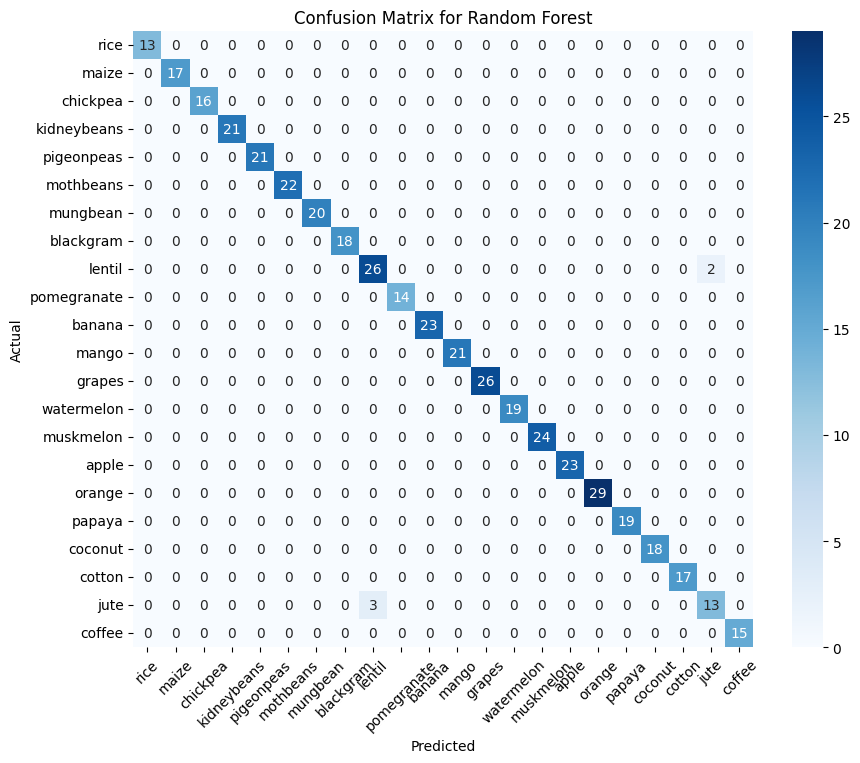

In [81]:
# Confusion Matrix Heatmap for Random Forest
from sklearn.metrics import confusion_matrix

# Predictions
y_pred_rf = RandomForest.predict(Xtest)
cm = confusion_matrix(Ytest, y_pred_rf)

# Plot heatmap
plt.figure(figsize=[10, 8])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [83]:
# Hyperparameter Tuning for Random Forest
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xtrain, Ytrain)

print("\nBest Parameters for Random Forest:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on test set
best_rf = grid_search.best_estimator_
test_accuracy = accuracy_score(Ytest, best_rf.predict(Xtest))
print("Test Accuracy with Best Model:", test_accuracy)


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.9971590909090908
Test Accuracy with Best Model: 0.9886363636363636


In [84]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(random_state=2)

LogReg.fit(Xtrain,Ytrain)

predicted_values = LogReg.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Logistic Regression')
print("Logistic Regression's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

Logistic Regression's Accuracy is:  0.9613636363636363
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.80      1.00      0.89        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.84      0.93      0.88        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      0.95      0.98        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      0.89      0.94        19
    mungbean       0.92      1.00      0.96        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00   

In [87]:
# K-NEAREST NEIGHBORS (KNN)
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(Xtrain, Ytrain)
predicted_values = KNN.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('KNN')
print("KNN's Accuracy is: ", x*100)
print(classification_report(Ytest, predicted_values))

KNN's Accuracy is:  97.27272727272728
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       0.89      1.00      0.94        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.88      1.00      0.93        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       0.96      1.00      0.98        23
       maize       1.00      1.00      1.00        21
       mango       0.93      1.00      0.96        26
   mothbeans       1.00      0.79      0.88        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      0.93      0.96

In [89]:
# GRADIENT BOOSTING
from sklearn.ensemble import GradientBoostingClassifier

GradBoost = GradientBoostingClassifier(n_estimators=100, random_state=2)
GradBoost.fit(Xtrain, Ytrain)
predicted_values = GradBoost.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Gradient Boosting')
print("Gradient Boosting's Accuracy is: ", x*100)
print(classification_report(Ytest, predicted_values))

Gradient Boosting's Accuracy is:  98.63636363636363
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      0.95      0.98        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.89      0.89      0.89        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      

In [90]:
# Ensure Xtest is a DataFrame with correct columns
if not isinstance(Xtest, pd.DataFrame):
    Xtest = pd.DataFrame(Xtest, columns=df.drop('label', axis=1).columns)
if not isinstance(Xtrain, pd.DataFrame):
    Xtrain = pd.DataFrame(Xtrain, columns=df.drop('label', axis=1).columns)

# Verify feature names
feature_names = df.drop('label', axis=1).columns.tolist()
print("Features used for training:", feature_names)
print("Xtrain shape:", Xtrain.shape)
print("Xtest shape:", Xtest.shape)

Features used for training: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'N_P_ratio', 'temp_humidity', 'ph_rainfall']
Xtrain shape: (1760, 10)
Xtest shape: (440, 10)


In [137]:
# XGBoost Model
print("\nTraining XGBoost...")
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(df['label'].unique()),
    random_state=42,
    eval_metric='mlogloss'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Ytrain_encoded = le.fit_transform(Ytrain)
Ytest_encoded = le.transform(Ytest)

xgb_model.fit(Xtrain, Ytrain_encoded)

y_pred_xgb = xgb_model.predict(Xtest)
y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)
xgb_accuracy = accuracy_score(Ytest, y_pred_xgb_labels)
print("XGBoost Accuracy:", xgb_accuracy)
print("\nXGBoost Classification Report:")
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(Ytest, y_pred_xgb_labels))

from sklearn.model_selection import cross_val_score
xgb_cv_scores = cross_val_score(xgb_model, Xtrain, Ytrain_encoded, cv=5, scoring='accuracy')
print("XGBoost CV Accuracy: {:.4f} ± {:.4f}".format(xgb_cv_scores.mean(), xgb_cv_scores.std()))


Training XGBoost...
XGBoost Accuracy: 0.9931818181818182

XGBoost Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      0.95      0.98        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.93      1.00      0.97        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       0.96      1.00      0.98        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.00  

In [111]:
# LightGBM Model
print("\nTraining LightGBM...")
from lightgbm import LGBMClassifier
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(df['label'].unique()),
    random_state=42,
    verbose=-1
)

# Label encode target (reuse le from XGBoost if defined)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Ytrain_encoded = le.fit_transform(Ytrain)
Ytest_encoded = le.transform(Ytest)

# Train model
lgb_model.fit(Xtrain, Ytrain_encoded)

# Predict and evaluate
y_pred_lgb = lgb_model.predict(Xtest)
y_pred_lgb_labels = le.inverse_transform(y_pred_lgb)
lgb_accuracy = accuracy_score(Ytest, y_pred_lgb_labels)
print("LightGBM Accuracy:", lgb_accuracy)
print("\nLightGBM Classification Report:")
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(Ytest, y_pred_lgb_labels))

# Cross-validation
from sklearn.model_selection import cross_val_score
lgb_cv_scores = cross_val_score(lgb_model, Xtrain, Ytrain_encoded, cv=5, scoring='accuracy')
print("LightGBM CV Accuracy: {:.4f} ± {:.4f}".format(lgb_cv_scores.mean(), lgb_cv_scores.std()))


Training LightGBM...
LightGBM Accuracy: 0.9886363636363636

LightGBM Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      0.95      0.98        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.93      0.93      0.93        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       0.96      1.00      0.98        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.0

In [113]:
# CatBoost Model
print("\nTraining CatBoost...")
from catboost import CatBoostClassifier
cb_model = CatBoostClassifier(
    loss_function='MultiClass',
    random_state=42,
    verbose=0
)

# Label encode target (reuse le if defined)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Ytrain_encoded = le.fit_transform(Ytrain)
Ytest_encoded = le.transform(Ytest)

# Train model
cb_model.fit(Xtrain, Ytrain_encoded)

# Predict and evaluate
y_pred_cb = cb_model.predict(Xtest)
y_pred_cb_labels = le.inverse_transform(y_pred_cb.flatten())
cb_accuracy = accuracy_score(Ytest, y_pred_cb_labels)
print("CatBoost Accuracy:", cb_accuracy)
print("\nCatBoost Classification Report:")
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(Ytest, y_pred_cb_labels))

# Cross-validation
from sklearn.model_selection import cross_val_score
cb_cv_scores = cross_val_score(cb_model, Xtrain, Ytrain_encoded, cv=5, scoring='accuracy')
print("CatBoost CV Accuracy: {:.4f} ± {:.4f}".format(cb_cv_scores.mean(), cb_cv_scores.std()))


Training CatBoost...
CatBoost Accuracy: 0.9863636363636363

CatBoost Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.92      0.86      0.89        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       1.00      1.00      1.00        24
   muskmelon       1.00      1.00      1.0

In [122]:
# SVM (RBF)
from sklearn.svm import SVC

SVM_RBF = SVC(kernel='rbf', random_state=2, probability=True)
SVM_RBF.fit(Xtrain, Ytrain)
predicted_values = SVM_RBF.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('SVM (RBF)')
print("SVM (RBF)'s Accuracy is: ", x*100)
print(classification_report(Ytest, predicted_values))

SVM (RBF)'s Accuracy is:  97.95454545454545
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        13
      banana       1.00      1.00      1.00        17
   blackgram       1.00      1.00      1.00        16
    chickpea       1.00      1.00      1.00        21
     coconut       1.00      1.00      1.00        21
      coffee       1.00      1.00      1.00        22
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        18
        jute       0.80      1.00      0.89        28
 kidneybeans       1.00      1.00      1.00        14
      lentil       1.00      1.00      1.00        23
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        26
   mothbeans       1.00      1.00      1.00        19
    mungbean       0.96      1.00      0.98        24
   muskmelon       1.00      1.00      1.00        23
      orange       1.00      1.00    

Decision Tree Accuracy: 0.9841
Naive Bayes Accuracy: 0.9909
SVM (Linear) Accuracy: 0.9841
Logistic Regression Accuracy: 0.9614
Random Forest Accuracy: 0.9909
KNN Accuracy: 0.9727
Gradient Boosting Accuracy: 0.9886
SVM (RBF) Accuracy: 0.9795
XGBoost Accuracy: 0.9932
LightGBM Accuracy: 0.9886
CatBoost Accuracy: 0.9864


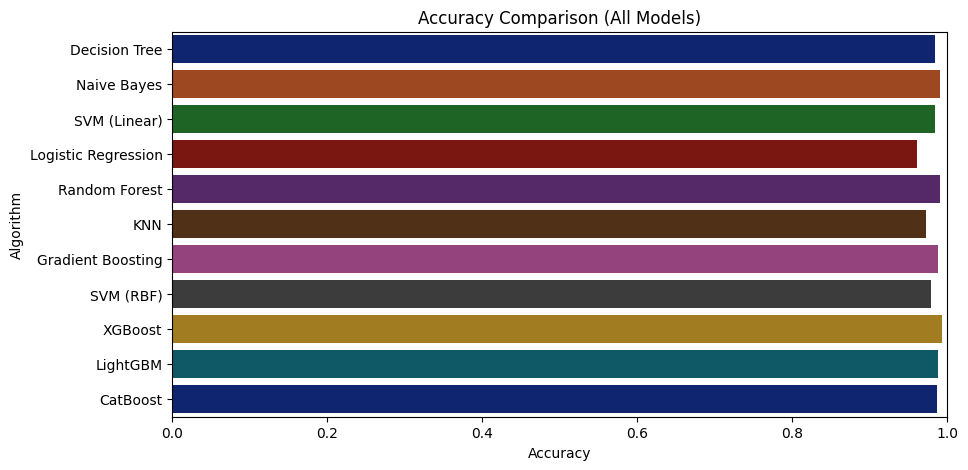

In [139]:
# Updated Accuracy Comparison with All Models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define model names and trained models
models = {
    'Decision Tree': DecisionTree,
    'Naive Bayes': NaiveBayes,
    'SVM (Linear)': SVM_Linear,
    'Logistic Regression': LogReg,
    'Random Forest': RandomForest,
    'KNN': KNN,
    'Gradient Boosting': GradBoost,
    'SVM (RBF)': SVM_RBF,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cb_model
}

# Compute accuracies
acc = []
model_names = []
for name, model in models.items():
    if name in ['XGBoost', 'LightGBM', 'CatBoost']:
        # Predict using encoded labels and convert back
        y_pred = model.predict(Xtest)
        y_pred_labels = le.inverse_transform(y_pred)
        accuracy = accuracy_score(Ytest, y_pred_labels)
    else:
        # Predict directly for other models
        y_pred = model.predict(Xtest)
        accuracy = accuracy_score(Ytest, y_pred)
    acc.append(accuracy)
    model_names.append(name)
    print(f"{name} Accuracy: {accuracy:.4f}")

# Create bar plot
plt.figure(figsize=[10, 5], dpi=100)
plt.title('Accuracy Comparison (All Models)')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x=acc, y=model_names, palette='dark')
plt.xlim(0, 1)  # Ensure x-axis ranges from 0 to 1
plt.show()

In [125]:
#XGBOOST
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert string labels to numerical labels
Ytrain_encoded = label_encoder.fit_transform(Ytrain)
Ytest_encoded = label_encoder.transform(Ytest)

# Train XGBClassifier
XB = xgb.XGBClassifier()
XB.fit(Xtrain, Ytrain_encoded)

# Predict
predicted_values = XB.predict(Xtest)

# Convert predictions back to original labels if needed
predicted_labels = label_encoder.inverse_transform(predicted_values)

# Check accuracy
from sklearn import metrics
accuracy = metrics.accuracy_score(Ytest_encoded, predicted_values)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9931818181818182


In [126]:
# Cross validation score (XGBoost)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# Encode target labels
encoder = LabelEncoder()
target_encoded = encoder.fit_transform(target)

# Perform cross-validation
score = cross_val_score(XB, features, target_encoded, cv=5)
print(score)


[0.99318182 0.98863636 0.99318182 0.99772727 0.98863636]


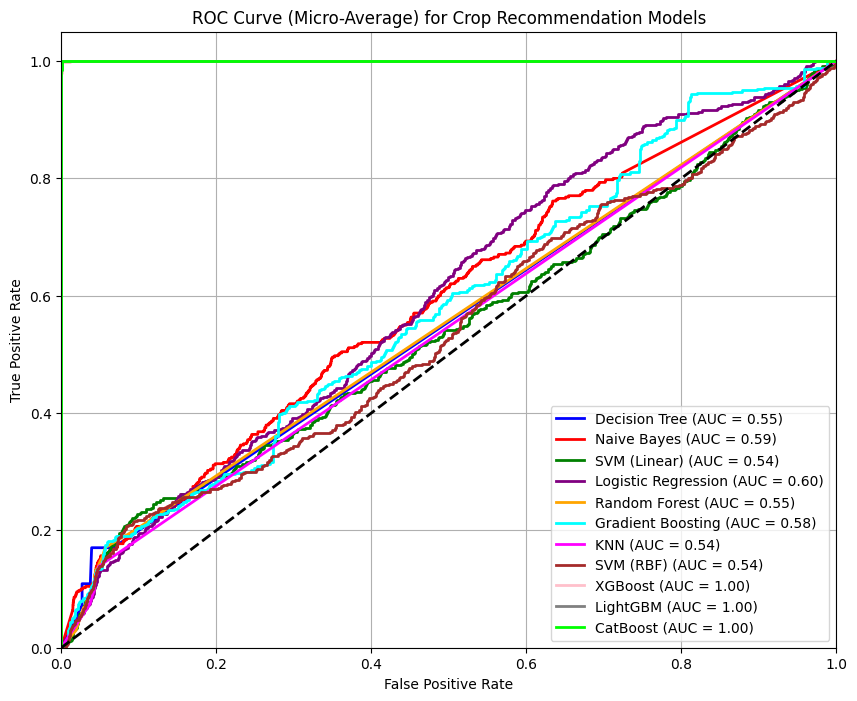

In [129]:
# ROC Curve for All Models
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

models_dict = {
    'Decision Tree': DecisionTree,
    'Naive Bayes': NaiveBayes,
    'SVM (Linear)': SVM_Linear,
    'Logistic Regression': LogReg,
    'Random Forest': RandomForest,
    'Gradient Boosting': GradBoost,
    'KNN': KNN,
    'SVM (RBF)': SVM_RBF,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cb_model
}

# Binarize the test labels
y_test_bin = label_binarize(Ytest, classes=df['label'].unique())
n_classes = y_test_bin.shape[1]

plt.figure(figsize=[10, 8])
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'pink', 'gray', 'lime'])
lw = 2

for name, clf in models_dict.items():
    if name in ['XGBoost', 'LightGBM', 'CatBoost']:
        # Predict probabilities using encoded labels, map to original classes
        y_score = clf.predict_proba(Xtest)
        # Create a mapping for encoded to original labels
        label_mapping = {i: label for i, label in enumerate(le.classes_)}
        # Ensure y_score aligns with y_test_bin classes
        y_score_ordered = np.zeros_like(y_score)
        for i, label in enumerate(df['label'].unique()):
            if label in label_mapping.values():
                encoded_idx = list(label_mapping.values()).index(label)
                y_score_ordered[:, i] = y_score[:, encoded_idx]
        y_score = y_score_ordered
    else:
        y_score = clf.predict_proba(Xtest)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], color=next(colors), lw=lw,
             label=f'{name} (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Micro-Average) for Crop Recommendation Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [145]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(xgb.XGBClassifier(objective='multi:softmax', num_class=22, random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(Xtrain, Ytrain_encoded)
print("Best XGBoost Params:", grid_search.best_params_)
xgb_model = grid_search.best_estimator_

Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


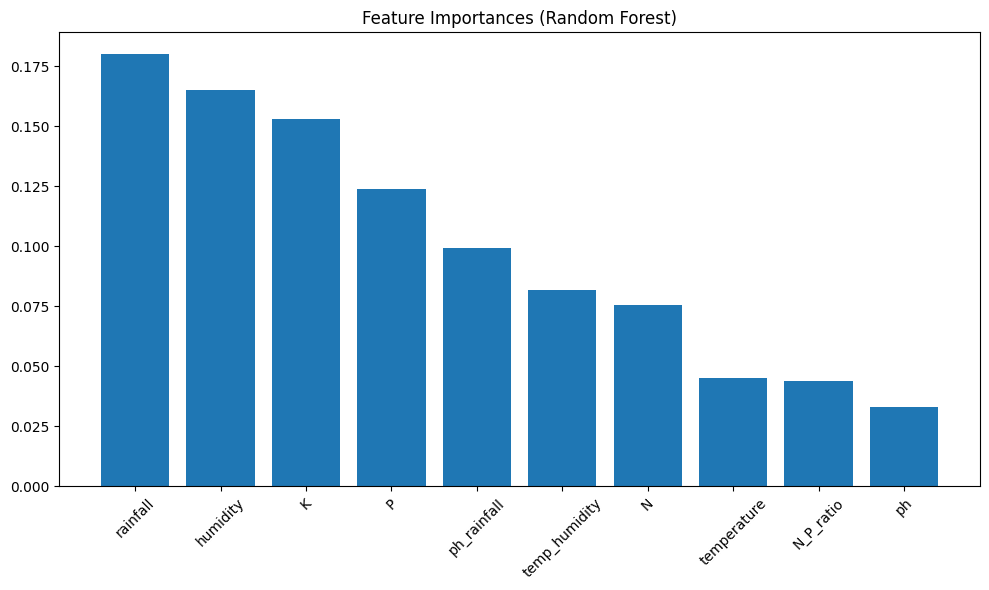

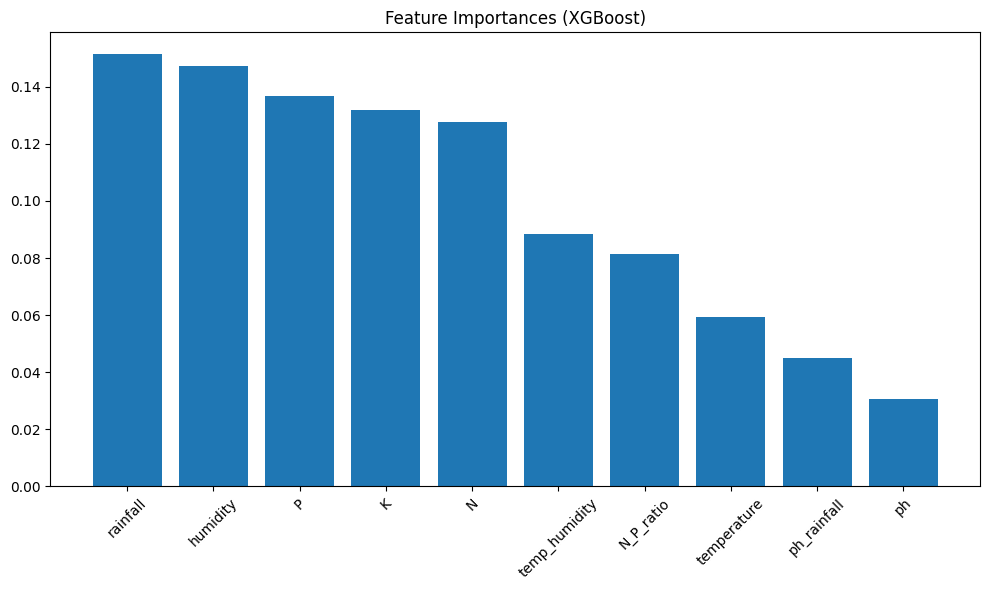

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance from Random Forest
importances = RandomForest.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=[10, 6])
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# Feature importance from XGBoost
xgb_importances = xgb_model.feature_importances_
indices_xgb = np.argsort(xgb_importances)[::-1]
plt.figure(figsize=[10, 6])
plt.title("Feature Importances (XGBoost)")
plt.bar(range(X.shape[1]), xgb_importances[indices_xgb], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices_xgb], rotation=45)
plt.tight_layout()
plt.show()

In [171]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Verify models are defined
print("Checking model definitions:")
print("xgb_model:", "defined" if 'xgb_model' in globals() else "not defined")
print("lgb_model:", "defined" if 'lgb_model' in globals() else "not defined")
print("cb_model:", "defined" if 'cb_model' in globals() else "not defined")

# Create ensemble
try:
    ensemble = VotingClassifier(estimators=[
        ('xgb', xgb_model), ('lgb', lgb_model), ('cb', cb_model)
    ], voting='soft')
    print("Ensemble created successfully.")

    # Fit ensemble
    print("Fitting ensemble...")
    ensemble.fit(Xtrain, Ytrain_encoded)
    print("Ensemble fitted successfully.")

    # Predict
    print("Predicting...")
    y_pred_ensemble = ensemble.predict(Xtest)
    y_pred_ensemble_labels = le.inverse_transform(y_pred_ensemble)
    
    # Calculate and print accuracy
    ensemble_accuracy = accuracy_score(Ytest, y_pred_ensemble_labels)
    print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
    
    # Verify shapes for debugging
    print("Xtest shape:", Xtest.shape)
    print("Ytest shape:", Ytest.shape)
    print("y_pred_ensemble_labels shape:", y_pred_ensemble_labels.shape)

except Exception as e:
    print(f"Error occurred: {e}")

Checking model definitions:
xgb_model: defined
lgb_model: defined
cb_model: defined
Ensemble created successfully.
Fitting ensemble...
Ensemble fitted successfully.
Predicting...
Ensemble Accuracy: 0.9886
Xtest shape: (440, 10)
Ytest shape: (440,)
y_pred_ensemble_labels shape: (440,)
